In [22]:
!pip install google-adk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 5.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
  Attempting uninstall: cachetools
    Found existing installation: cachetools 6.2.1
    Uninstalling cachetools-6.2.1:
      Successfully uninstalled cachetools-6.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.5 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich

In [23]:
import os
from kaggle_secrets import UserSecretsClient

try:
    GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
    print('Gemini API key setup complete')
except Exception as e:
    print(
        f"Authentication Error: Please make sure you have added 'GOOGLE_API_KEY' to your Kaggle secrets. Details: {e}"
    )

Gemini API key setup complete


In [24]:
from google.adk.agents import Agent, SequentialAgent, ParallelAgent, LoopAgent
from google.adk.models.google_llm import Gemini
from google.adk.runners import InMemoryRunner
from google.adk.tools import AgentTool, FunctionTool, google_search
from google.genai import types

print(" ADK components imported successfully.")

 ADK components imported successfully.


# Why Multi-Agent Systems ?

Multi-agent systems break a complex application into multiple specialized agents that work together to solve problems. <br>
Instead of relying on a single agent to handle every step, multi-agent architectures allow you to compose smaller, focused agents into a coordinated workflow. <br>

Multi-agent systems are useful when:
- A single agent has too many tools and makes poor decisions about which to use
- Context or memory grows too large for one agent to track effectively
- Tasks require specialization (eg a planner, researcher, math expert)



# Tool Calling - 
- A supervisor agent calls other agents as tools. The “tool” agents don’t talk to the user directly — they just run their task and return results
- Centralized: all routing passes through the calling agent.

# HandOffs - 
- The current agent decides to transfer control to another agent. The active agent changes, and the user may continue interacting directly with the new agent.
- Decentralized: agents can change who is active.

**Let's build a system with two specialized agents:**

**Research Agent**   - Searches for information using Google Search <br>
**Summarizer Agent** - Creates concise summaries from research findings

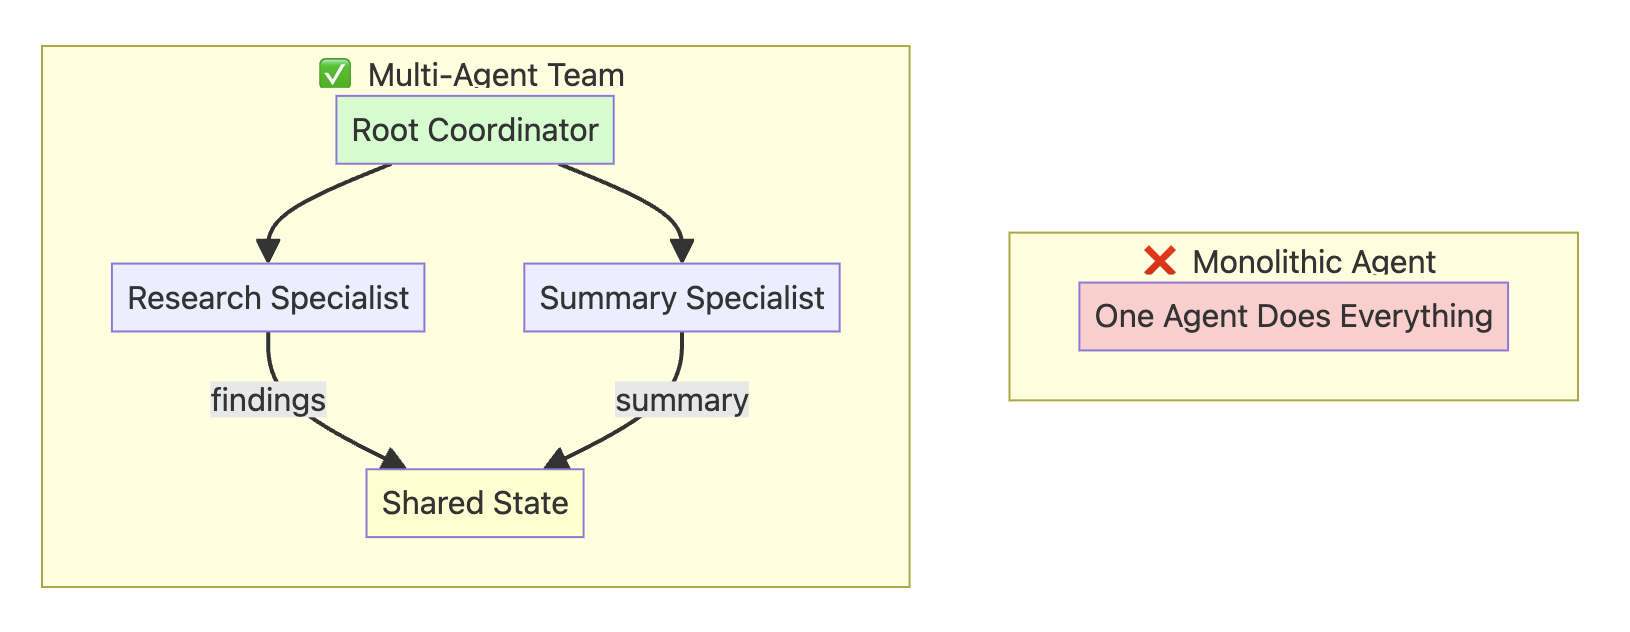
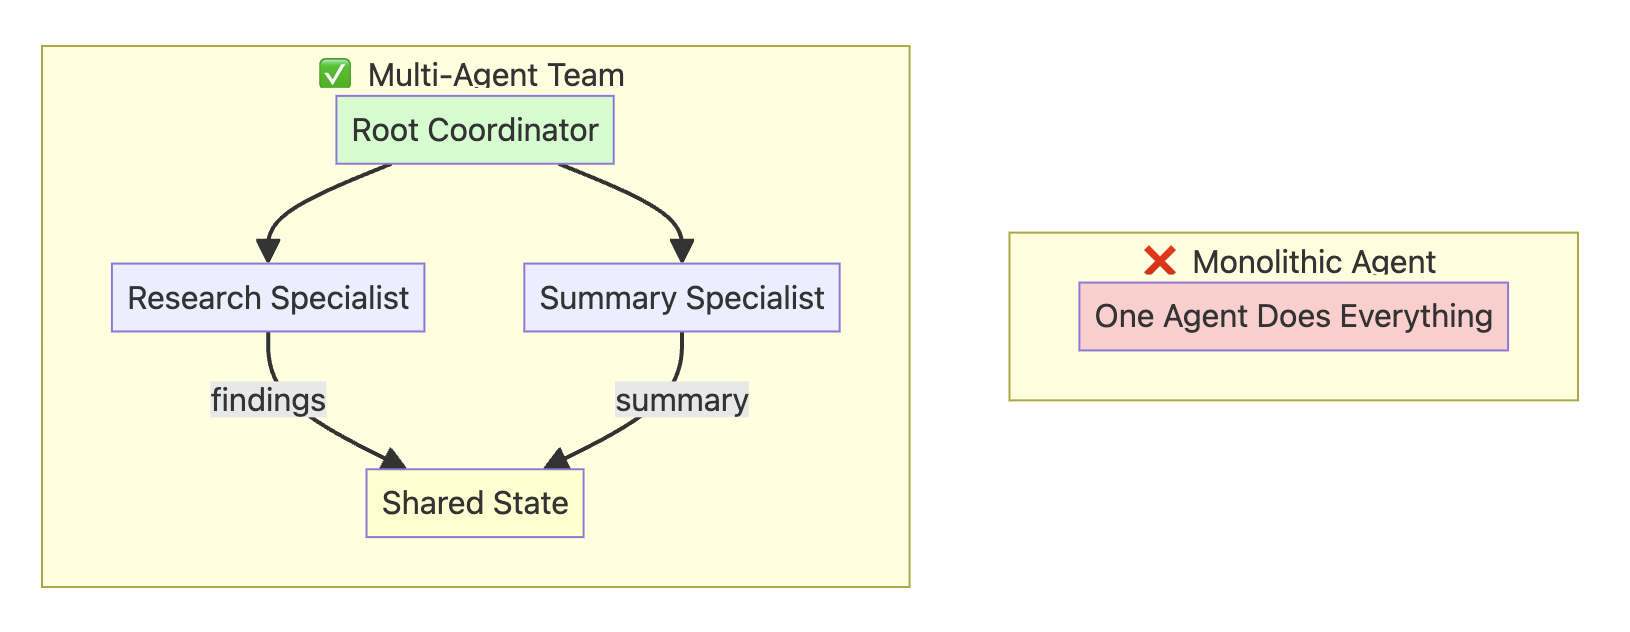

In [25]:
# When working with LLMs, you may encounter transient errors like rate limits or temporary service unavailability. 
# Retry options automatically handle these failures by retrying the request with exponential backoff.

retry_config=types.HttpRetryOptions(
    attempts=5,  # Maximum retry attempts
    exp_base=7,  # Delay multiplier
    initial_delay=1,
    http_status_codes=[429, 500, 503, 504], # Retry on these HTTP errors
)

In [26]:
# Research Agent: Its job is to use the google_search tool and present findings.

research_agent = Agent(name = 'ResearchAgent',model = Gemini(model = 'gemini-2.5-flash-lite', retry_options = retry_config),
    instruction="""You are a specialized research agent. Your only job is to use the
    google_search tool to find 2-3 pieces of relevant information on the given topic and present the findings with citations.""",
    tools=[google_search],
    output_key="research_findings",  # result of this agent will be stored in the session state with this key.
)

print('Research_Agent Created Successfully')

Research_Agent Created Successfully


- name='ResearchAgent' gives your agent a name helpful when you have multiple agents in a workflow.
- gemini-2.5-flash-lite is a fast, lightweight version of Gemini for quick responses
- retry_options = retry_config defines what to do if the model call fails, this improves reliability for production use.
- The agents job is to: Use the google_search tool find 2–3 relevant facts about the given topic and present results with citations (mention source URLs or names).
- After execution, the output is stored under "research_findings"

In [27]:
# Summarizer Agent: Its job is to summarize the text it receives.

summarizer_agent = Agent(name = 'SummarizerAgent', model = Gemini(model = 'gemini-2.5-flash-lite', retry_options = retry_config),
      instruction="""Read the provided research findings: {research_findings}
Create a concise summary as a bulleted list with 3-5 key points.""", output_key="final_summary")

print(' Summarizer_Agent Created Successfully')

 Summarizer_Agent Created Successfully


- name='SummarizerAgent' gives your agent a name helpful when you have multiple agents in a workflow.
- gemini-2.5-flash-lite is a fast, lightweight version of Gemini for quick responses
- retry_options = retry_config defines what to do if the model call fails, this improves reliability for production use.
- It receives the variable {research_findings} from the research agent. It reads that content carefully and produces a bullet-point summary for clarity.
- After execution, the output is stored under "final_summary"

Refer to the ADK documentation for more information on [guiding agents with clear and specific instructions.](https://google.github.io/adk-docs/agents/llm-agents/) <br>
To learn more, check out the documentation related to [LLM agents in ADK.](https://google.github.io/adk-docs/agents/llm-agents/)

In [28]:
# Root Coordinator: Orchestrates the workflow by calling the sub-agents as tools.

root_agent = Agent( name='ResearchCoordinator',
    model=Gemini(model='gemini-2.5-flash-lite',
        retry_options=retry_config),
    
    instruction="""You are a research coordinator. Your goal is to answer the user's query by orchestrating a workflow.
1. First, you MUST call the `ResearchAgent` tool to find relevant information on the topic provided by the user.
2. Next, after receiving the research findings, you MUST call the `SummarizerAgent` tool to create a concise summary.
3. Finally, present the final summary clearly to the user as your response.""",
                   
    # We wrap the sub-agents in `AgentTool` to make them callable tools for the root agent.
    tools=[AgentTool(research_agent), AgentTool(summarizer_agent)])

print('Root_agent created')

Root_agent created


- step 1 - Call ResearchAgent tool Provide the user topic Fetch 2–3 findings with citations
- Step 2 - Call SummarizerAgent tool Take the research findings Convert them into a bullet-point summary
- Step 3 - Return final summary to user Clean, readable answer So the root agent behaves like an autonomous workflow engine.
- User -> root_agent ->  research_agent -> summarizer_agent -> final answer

**InMemoryRunner(agent = root_agent)** <br>
Manages the full multi-agent workflow Tracks intermediate outputs (research_findings, final_summary) <br>
Shows tool calls Displays detailed reasoning with .run_debug() <br> 
No external storage --> everything runs in RAM.

What happens internally:  <br>

Step 1 — Root agent reads user query <br>

→ Follows its instruction <br>
→ MUST call ResearchAgent <br>

Step 2 — ResearchAgent runs <br>

→ Runs google_search <br>
→ Collects 2–3 latest updates about cloud data engineering <br>
→ Stores output in research_findings <br>

Step 3 — Root agent receives the findings <br>

→ MUST call SummarizerAgent <br>

Step 4 — SummarizerAgent runs <br>

→ Summarizes the research findings into 3–5 bullet points <br>
→ Stores output in final_summary <br>

Step 5 — Root agent returns final answer <br>

→ The value in final_summary becomes the final output <br>
→ Assigned to the variable response <br>

In [35]:
runner = InMemoryRunner(agent = root_agent)

response = await runner.run_debug('What are the latest advancements in Cloud Data Engineering ?')


 ### Created new session: debug_session_id

User > What are the latest advancements in Cloud Data Engineering ?
OutlineAgent > Sure, I am OutlineAgent. Here is a blog outline for the topic "Latest Advancements in Cloud Data Engineering":

## Blog Outline: Latest Advancements in Cloud Data Engineering

**1. Catchy Headline:** Beyond the Cloud: Next-Gen Data Engineering is Here!

**2. Introduction Hook:**
    * The cloud has revolutionized data storage and processing, but the pace of innovation is relentless.
    * What was cutting-edge yesterday is standard practice today. Are you ready for the next wave of cloud data engineering advancements that are reshaping how we manage and leverage data?

**3. Main Sections:**

    *   **Section 1: The Rise of Generative AI in Data Pipelines**
        *   AI-powered data quality and anomaly detection: Automatically identifying and rectifying data issues.
        *   Automated ETL/ELT script generation and optimization: Accelerating development an

--------------------------------------

==================================================================================================================================================================================================

Sequential Workflows - The Assembly Line <br>

The Problem: Unpredictable Order <br>

The previous multi-agent system worked, but it relied on a detailed instruction prompt to force the LLM to run steps in order. <br> 
This can be unreliable. A complex LLM might decide to skip a step, run them in the wrong order, or get "stuck," making the process unpredictable. <br>

The Solution: A Fixed Pipeline <br>

When you need tasks to happen in a guaranteed, specific order, you can use a SequentialAgent. <br> 
This agent acts like an assembly line, running each sub-agent in the exact order you list them. <br>
The output of one agent automatically becomes the input for the next, creating a predictable and reliable workflow. <br>

Use Sequential when: Order matters, you need a linear pipeline, or each step builds on the previous one. <br>

To learn more, check out the documentation related to [sequential agents in ADK](https://google.github.io/adk-docs/agents/workflow-agents/sequential-agents/)

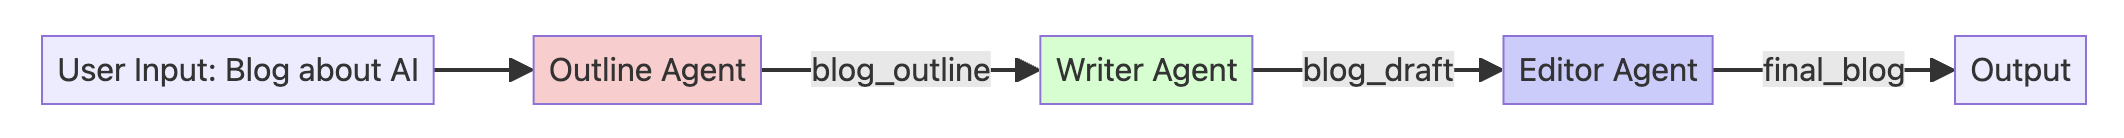
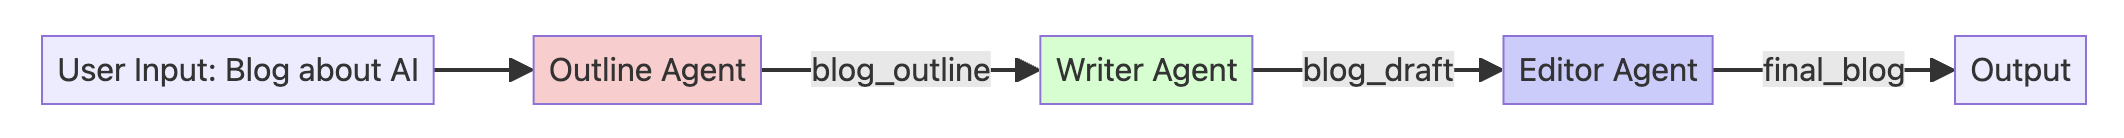

Blog Post Creation with Sequential Agents <br>
Let's build a system with three specialized agents: <br>

Outline Agent - Creates a blog outline for a given topic <br>
Writer Agent - Writes a blog post <br>
Editor Agent - Edits a blog post draft for clarity and structure <br>

In [30]:
# Outline Agent: Creates the initial blog post outline.
outline_agent = Agent(
    name="OutlineAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    instruction="""Create a blog outline for the given topic with:
    1. A catchy headline
    2. An introduction hook
    3. 3-5 main sections with 2-3 bullet points for each
    4. A concluding thought""",
    output_key="blog_outline",  # The result of this agent will be stored in the session state with this key.
)

print("outline_agent created.")

outline_agent created.



1. Creates an AI agent named OutlineAgent whose job is to generate blog post outlines.
2. Uses the Gemini model (gemini-2.5-flash-lite) for fast and efficient text generation.
3. Includes retry logic (retry_options=retry_config) to make the agent more reliable during API failures.
4. Defines a clear instruction prompt that tells the agent
     - to produce blog headline
     - An engaging introduction
     - 3–5 main sections with sub-points
     - conclusion
5. Stores the agent's output under the key "blog_outline", making it easy to access later in the workflow.
6. Designed to be used inside a multi-agent system, where this agent is responsible only for the outline step.


In [31]:
# Writer Agent: Writes the full blog post based on the outline from the previous agent.
writer_agent = Agent(
    name="WriterAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    # The `{blog_outline}` placeholder automatically injects the state value from the previous agent's output.
    instruction="""Following this outline strictly: {blog_outline}
    Write a brief, 200 to 300-word blog post with an engaging and informative tone.""",
    output_key="blog_draft",  # The result of this agent will be stored with this key.
)

print("writer_agent created.")

writer_agent created.


1. Creates an AI agent named WriterAgent responsible for writing the full blog draft.

2. Uses Gemini (gemini-2.5-flash-lite) for fast and coherent content generation.

3. Accepts the blog outline automatically using the placeholder {blog_outline}, which is pulled from the previous agent’s output.

4. Instruction tells the agent to:

    - Follow the provided outline strictly
    - Produce a 200–300 word blog post
    - Maintain an engaging and informative tone

5. Saves the generated blog draft into session memory under the key "blog_draft".

6. Designed to be part of a multi-agent blogging workflow (Outline → Writing → Editing/Polishing).

In [32]:
# Editor Agent: Edits and polishes the draft from the writer agent.
editor_agent = Agent(
    name="EditorAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    # This agent receives the `{blog_draft}` from the writer agent's output.
    instruction="""Edit this draft: {blog_draft}
    Your task is to polish the text by fixing any grammatical errors, improving the flow and sentence structure, and enhancing overall clarity.""",
    output_key="final_blog",  # This is the final output of the entire pipeline.
)

print(" editor_agent created.")

 editor_agent created.


1. Creates an AI agent named EditorAgent that focuses on refining written content.

2. Receives input {blog_draft}, which is automatically pulled from the WriterAgent’s output.

3. Instruction tells the agent to:
     - Edit and polish the draft
     - Fix grammar and punctuation
     - Improve structure, clarity, and readability
     - Make the writing smooth and professional

4. Saves the polished output under the key "final_blog", marking it as the final result of the workflow.

5. Meant to be the third step in a blog-generation pipeline (Outline → Draft → Edit).

In [33]:
root_agent = SequentialAgent(name="BlogPipeline", sub_agents=[outline_agent, writer_agent, editor_agent])

print("Sequential Agent created.")

Sequential Agent created.


In [34]:
runner = InMemoryRunner(agent=root_agent)

response = await runner.run_debug("Write a blog post about the benefits of multi-agent systems for DevOps Engineers")


 ### Created new session: debug_session_id

User > Write a blog post about the benefits of multi-agent systems for DevOps Engineers
OutlineAgent > ## Outline:

**Headline:** Unleash the Power of Collaboration: How Multi-Agent Systems Are Revolutionizing DevOps

**Introduction Hook:** Imagine a DevOps team that's always on, constantly learning, and proactively solving problems before they even surface. That's the promise of Multi-Agent Systems (MAS) for DevOps engineers. Forget siloed tasks and manual interventions; MAS is ushering in an era of intelligent, autonomous collaboration that’s transforming how we build, deploy, and manage software.

**Main Sections:**

**1. Amplifying Efficiency and Automation**

*   **Intelligent Task Delegation:** MAS can distribute workload dynamically based on agent expertise and current system load, ensuring optimal resource utilization and faster task completion.
*   **Proactive Anomaly Detection & Resolution:** Agents can continuously monitor systems

==================================================================================================================================================================================================

==================================================================================================================================================================================================

**Parallel Workflows - Independent Researchers**# 

The Problem: The Bottleneck <br>

The previous sequential agent is great, but it's an assembly line. Each step must wait for the previous one to finish. <br>
What if you have several tasks that are not dependent on each other? <br>
For example, researching three different topics. Running them in sequence would be slow and inefficient, creating a bottleneck where each task waits unnecessarily. <br>

The Solution: Concurrent Execution <br>

When you have independent tasks, you can run them all at the same time using a ParallelAgent. <br>
This agent executes all of its sub-agents concurrently, dramatically speeding up the workflow. <br>
Once all parallel tasks are complete, you can then pass their combined results to a final 'aggregator' step. <br>

Use Parallel when: Tasks are independent, speed matters, and you can execute concurrently. <br>

To learn more, check out the documentation related to [parallel agents in ADK. ](https://google.github.io/adk-docs/agents/workflow-agents/parallel-agents/)

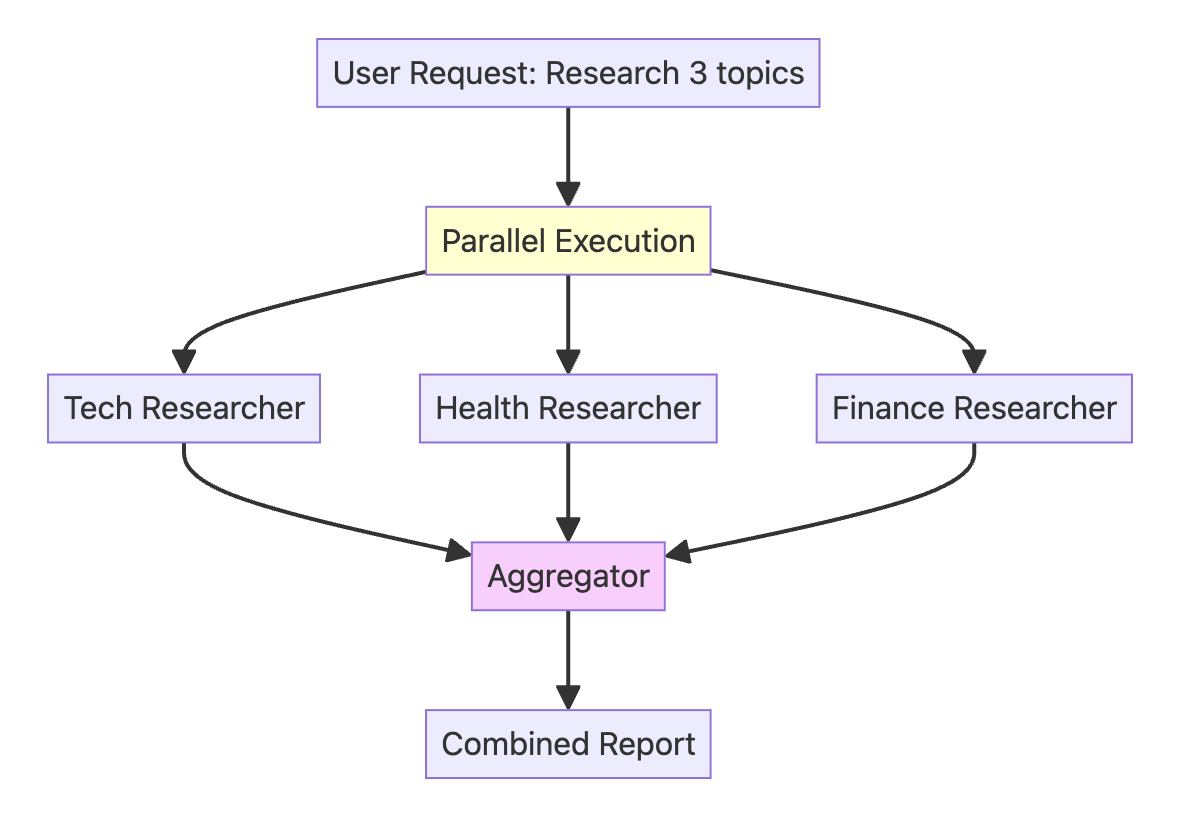
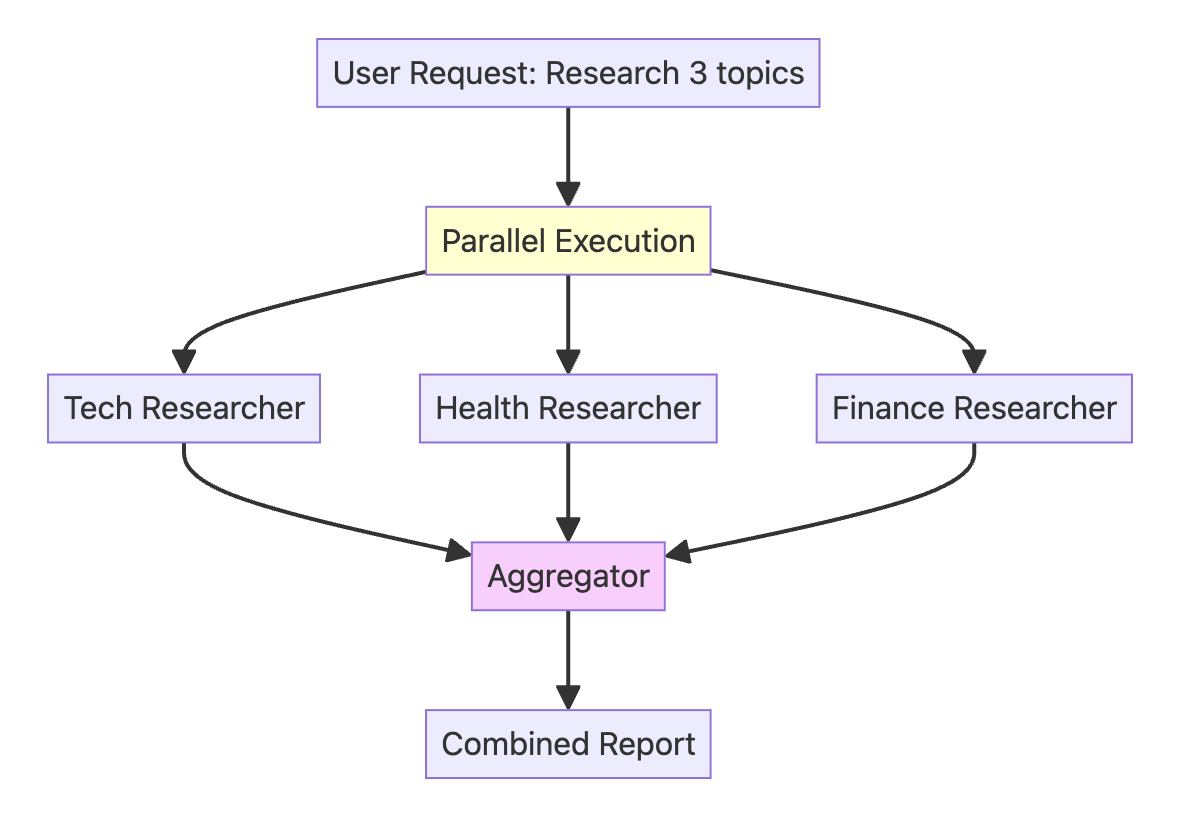

# **Parallel Multi-Topic Research**
Let's build a system with four agents:

1. Tech Researcher - Researches AI/ML news and trends
2. Health Researcher - Researches recent medical news and trends
3. Finance Researcher - Researches finance and fintech news and trends
4. Aggregator Agent - Combines all research findings into a single summary


In [36]:
# Tech Researcher: Focuses on AI and ML trends.
tech_researcher = Agent(
    name="TechResearcher",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    instruction="""Research the latest AI/ML trends. Include 3 key developments,
the main companies involved, and the potential impact. Keep the report very concise (100 words).""",
    tools=[google_search],
    output_key="tech_research",  # The result of this agent will be stored in the session state with this key.
)

print("tech_researcher created.")

tech_researcher created.


In [37]:
# Health Researcher: Focuses on medical breakthroughs.
health_researcher = Agent(
    name="HealthResearcher",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    instruction="""Research recent medical breakthroughs. Include 3 significant advances,
their practical applications, and estimated timelines. Keep the report concise (100 words).""",
    tools=[google_search],
    output_key="health_research",  # The result will be stored with this key.
)

print("health_researcher created.")

health_researcher created.


In [38]:
# Finance Researcher: Focuses on fintech trends.
finance_researcher = Agent(
    name="FinanceResearcher",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    instruction="""Research current fintech trends. Include 3 key trends,
their market implications, and the future outlook. Keep the report concise (100 words).""",
    tools=[google_search],
    output_key="finance_research",  # The result will be stored with this key.
)

print("finance_researcher created.")

finance_researcher created.


In [39]:
# The AggregatorAgent runs *after* the parallel step to synthesize the results.
aggregator_agent = Agent(
    name="AggregatorAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    # It uses placeholders to inject the outputs from the parallel agents, which are now in the session state.
    instruction="""Combine these three research findings into a single executive summary:

    **Technology Trends:**
    {tech_research}
    
    **Health Breakthroughs:**
    {health_research}
    
    **Finance Innovations:**
    {finance_research}
    
    Your summary should highlight common themes, surprising connections, and the most important key takeaways from all three reports. The final summary should be around 200 words.""",
    output_key="executive_summary",  # This will be the final output of the entire system.
)

print(" aggregator_agent created.")

 aggregator_agent created.


Then we bring the agents together under a parallel agent, which is itself nested inside of a sequential agent.

This design ensures that the research agents run first in parallel, then once all of their research is complete, the aggregator agent brings together all of the research findings into a single report:

In [40]:
# The ParallelAgent runs all its sub-agents simultaneously.
parallel_research_team = ParallelAgent(
    name="ParallelResearchTeam",
    sub_agents=[tech_researcher, health_researcher, finance_researcher],
)

# This SequentialAgent defines the high-level workflow: run the parallel team first, then run the aggregator.
root_agent = SequentialAgent(
    name="ResearchSystem",
    sub_agents=[parallel_research_team, aggregator_agent],
)

print("Parallel and Sequential Agents created.")

Parallel and Sequential Agents created.


In [41]:
runner = InMemoryRunner(agent=root_agent)

response = await runner.run_debug("Run the daily executive briefing on Tech, Health, and Finance")


 ### Created new session: debug_session_id

User > Run the daily executive briefing on Tech, Health, and Finance
FinanceResearcher > Here are three key fintech trends:

1.  **Embedded Finance:** This involves integrating financial services directly into non-financial platforms, such as e-commerce sites offering instant loans or payment options at checkout. Its market implication is a significant expansion of the embedded finance market, projected to reach hundreds of billions by 2030, and a shift towards "finance everywhere" experiences.

2.  **Artificial Intelligence (AI) and Machine Learning (ML):** AI/ML are revolutionizing financial services by automating tasks, enhancing customer support through chatbots, personalizing services, and improving fraud detection. The market impact is seen in increased efficiency, improved customer satisfaction, and significant growth in the AI in Fintech market, forecast to reach tens of billions.

3.  **Open Banking and API-Driven Innovation:** Open

==================================================================================================================================================================================================

==================================================================================================================================================================================================

# **Loop Workflows - The Refinement Cycle**

The Problem: One-Shot Quality

All the workflows we've seen so far run from start to finish. The SequentialAgent and ParallelAgent produce their final output and then stop. This 'one-shot' approach isn't good for tasks that require refinement and quality control. What if the first draft of our story is bad? We have no way to review it and ask for a rewrite.

The Solution: Iterative Refinement

When a task needs to be improved through cycles of feedback and revision, you can use a LoopAgent. A LoopAgent runs a set of sub-agents repeatedly until a specific condition is met or a maximum number of iterations is reached. This creates a refinement cycle, allowing the agent system to improve its own work over and over.

Use Loop when: Iterative improvement is needed, quality refinement matters, or you need repeated cycles.

To learn more, check out the documentation related to loop [agents in ADK.](https://google.github.io/adk-docs/agents/workflow-agents/loop-agents/)

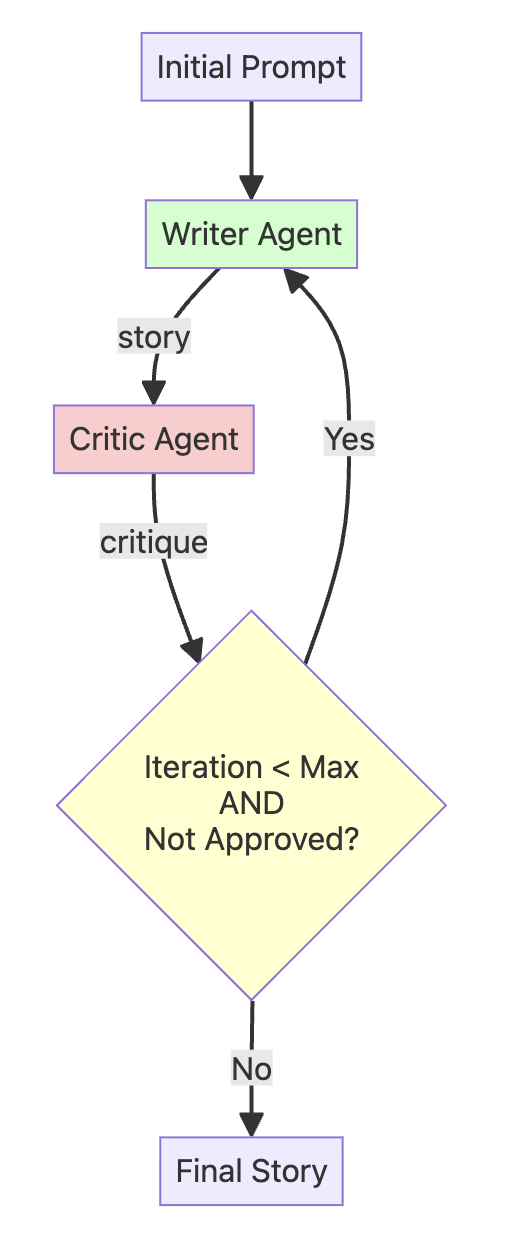
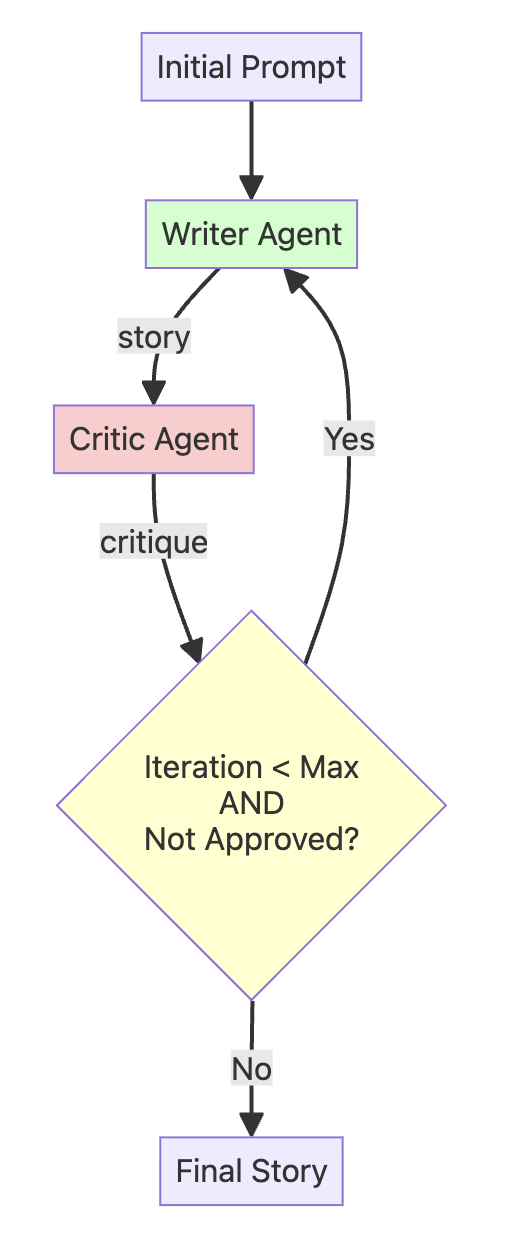

# **Iterative Story Refinement**
Let's build a system with two agents:

Writer Agent - Writes a draft of a short story
Critic Agent - Reviews and critiques the short story to suggest improvements


In [42]:
# This agent runs ONCE at the beginning to create the first draft.
initial_writer_agent = Agent(
    name="InitialWriterAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    instruction="""Based on the user's prompt, write the first draft of a short story (around 100-150 words).
    Output only the story text, with no introduction or explanation.""",
    output_key="current_story",  # Stores the first draft in the state.
)

print("initial_writer_agent created.")

initial_writer_agent created.


In [43]:
# This agent's only job is to provide feedback or the approval signal. It has no tools.
critic_agent = Agent(
    name="CriticAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    instruction="""You are a constructive story critic. Review the story provided below.
    Story: {current_story}
    
    Evaluate the story's plot, characters, and pacing.
    - If the story is well-written and complete, you MUST respond with the exact phrase: "APPROVED"
    - Otherwise, provide 2-3 specific, actionable suggestions for improvement.""",
    output_key="critique",  # Stores the feedback in the state.
)

print("critic_agent created.")

critic_agent created.



Now, we need a way for the loop to actually stop based on the critic's feedback. <br>The LoopAgent itself doesn't automatically know that "APPROVED" means "stop."  <br>

We need an agent to give it an explicit signal to terminate the loop.  <br>
We do this in two parts:  <br>A
simple Python function that the LoopAgent understands as an "exit" signal.  <br>
An agent that can call that function when the right condition is met.  <br>

First, you'll define the exit_loop function:


In [44]:
# This is the function that the RefinerAgent will call to exit the loop.
def exit_loop():
    """Call this function ONLY when the critique is 'APPROVED', indicating the story is finished and no more changes are needed."""
    return {"status": "approved", "message": "Story approved. Exiting refinement loop."}


print("exit_loop function created.")

exit_loop function created.


To let an agent call this Python function, we wrap it in a FunctionTool. Then, we create a RefinerAgent that has this tool.

Notice its instructions: 
this agent is the "brain" of the loop. It reads the {critique} from the CriticAgent and decides whether to (1) call the exit_loop tool or (2) rewrite the story.

In [45]:
# This agent refines the story based on critique OR calls the exit_loop function.
refiner_agent = Agent(
    name="RefinerAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    instruction="""You are a story refiner. You have a story draft and critique.
    
    Story Draft: {current_story}
    Critique: {critique}
    
    Your task is to analyze the critique.
    - IF the critique is EXACTLY "APPROVED", you MUST call the `exit_loop` function and nothing else.
    - OTHERWISE, rewrite the story draft to fully incorporate the feedback from the critique.""",
    output_key="current_story",  # It overwrites the story with the new, refined version.
    tools=[
        FunctionTool(exit_loop)
    ],  # The tool is now correctly initialized with the function reference.
)

print("refiner_agent created.")

refiner_agent created.


In [46]:
# The LoopAgent contains the agents that will run repeatedly: Critic -> Refiner.
story_refinement_loop = LoopAgent(
    name="StoryRefinementLoop",
    sub_agents=[critic_agent, refiner_agent],
    max_iterations=2,  # Prevents infinite loops
)

# The root agent is a SequentialAgent that defines the overall workflow: Initial Write -> Refinement Loop.
root_agent = SequentialAgent(
    name="StoryPipeline",
    sub_agents=[initial_writer_agent, story_refinement_loop],
)

print("Loop and Sequential Agents created.")

Loop and Sequential Agents created.


In [47]:
runner = InMemoryRunner(agent=root_agent)
response = await runner.run_debug("Write a short story about a lighthouse keeper who discovers a mysterious, glowing bottle of diamonds")


 ### Created new session: debug_session_id

User > Write a short story about a lighthouse keeper who discovers a mysterious, glowing bottle of diamonds
InitialWriterAgent > Elias traced the worn edges of his logbook, the salty air a familiar companion. For forty years, the beam of his lighthouse had cut through the inky blackness. Tonight, however, a strange luminescence flickered on the horizon, not the steady pulse of a ship. He grabbed his spyglass. It was a bottle, bobbing erratically, radiating an unnatural, diamond-like glow.

With the morning tide, the bottle washed ashore. Elias, his heart thrumming, retrieved it. Inside, not liquid, but a cascade of tiny, perfect diamonds shimmered. They pulsed with the same soft light he'd seen from the tower. He uncorked it, a faint, sweet scent escaping. The diamonds tumbled into his palm, cool and impossibly bright, a treasure born from the sea's deepest secrets.
CriticAgent > This is a lovely little vignette with a strong sense of atmosp

-----------------------------------------------------------------

-------------------------------------------------


**we now implemented a loop agent, creating a sophisticated system that can iteratively review and improve its own output. <br>This is a key pattern for ensuring high-quality results. <br>You now have a complete toolkit of workflow patterns. <br> Let's put it all together and review how to choose the right one for your use case.**


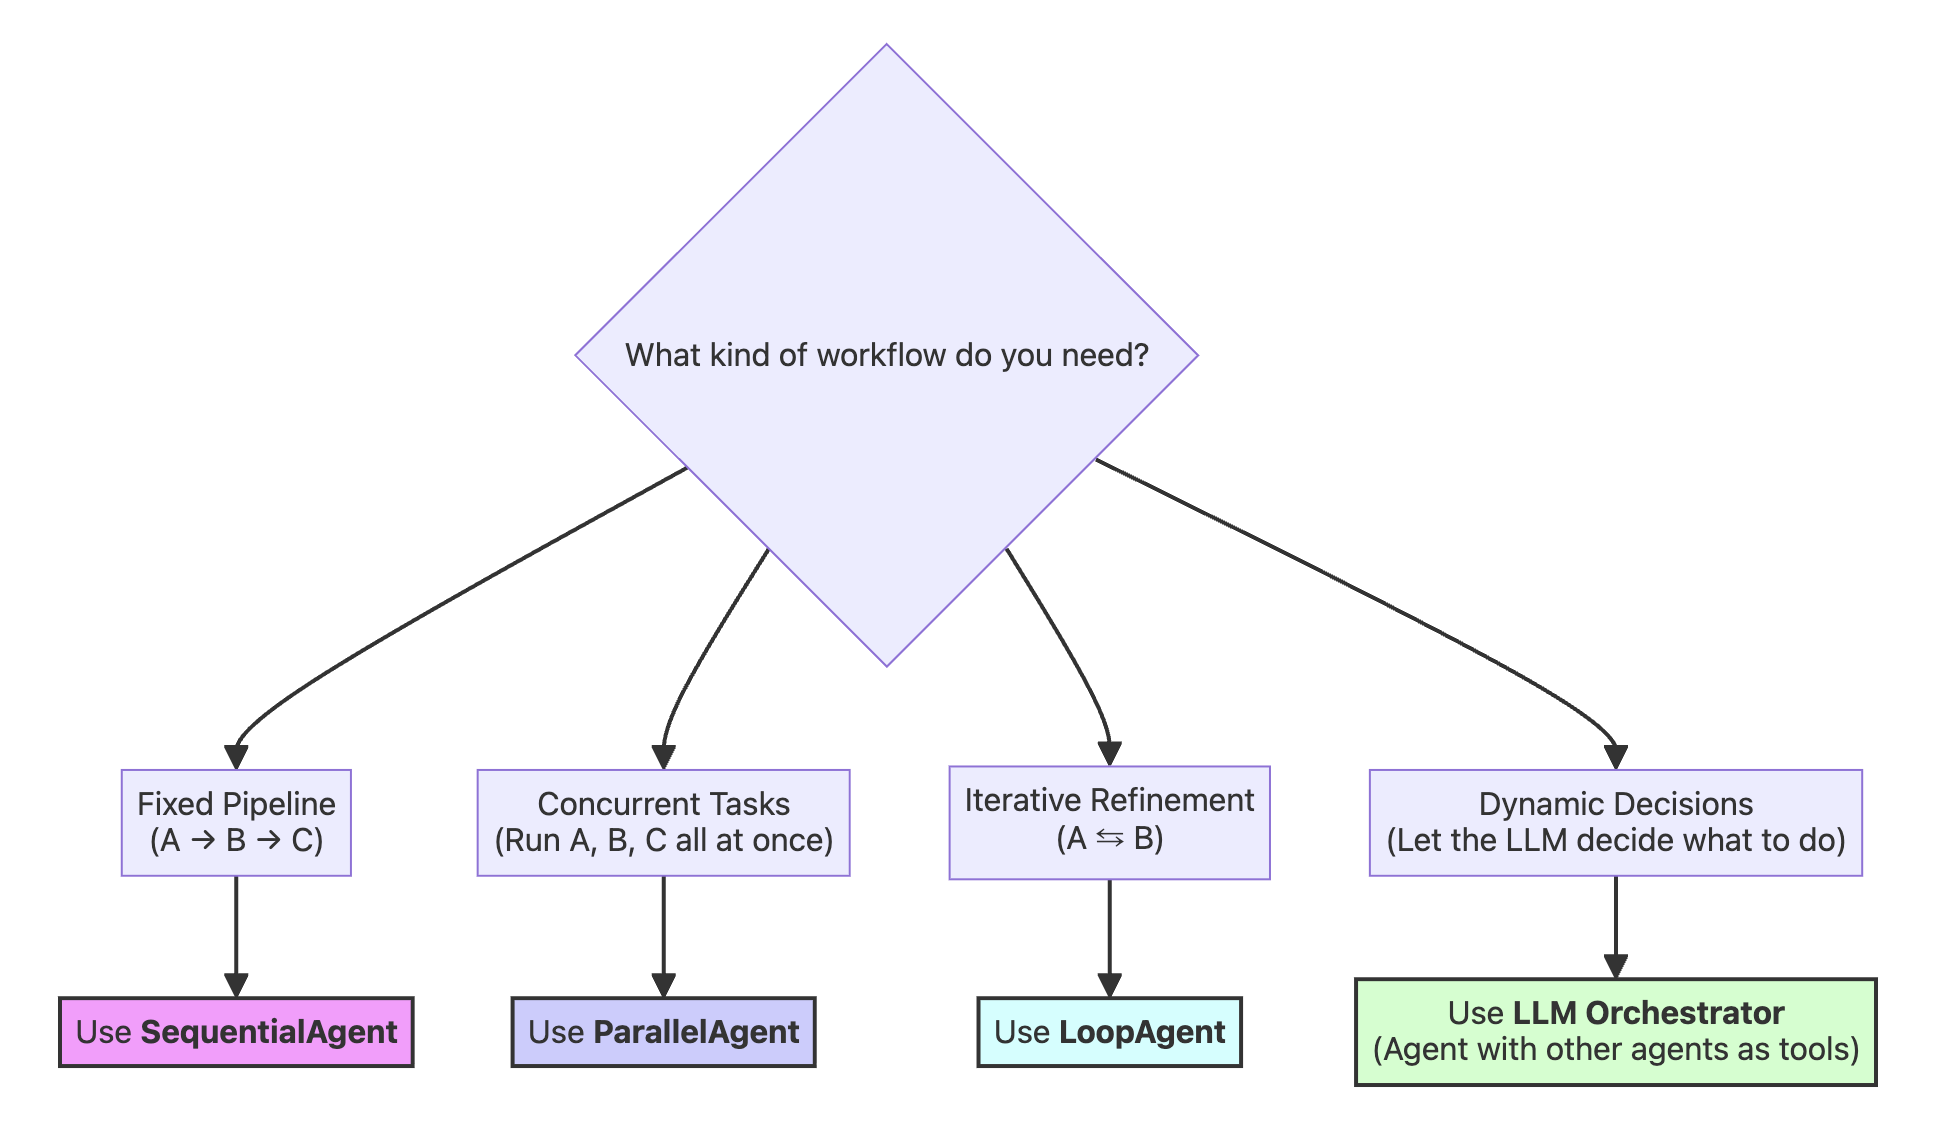
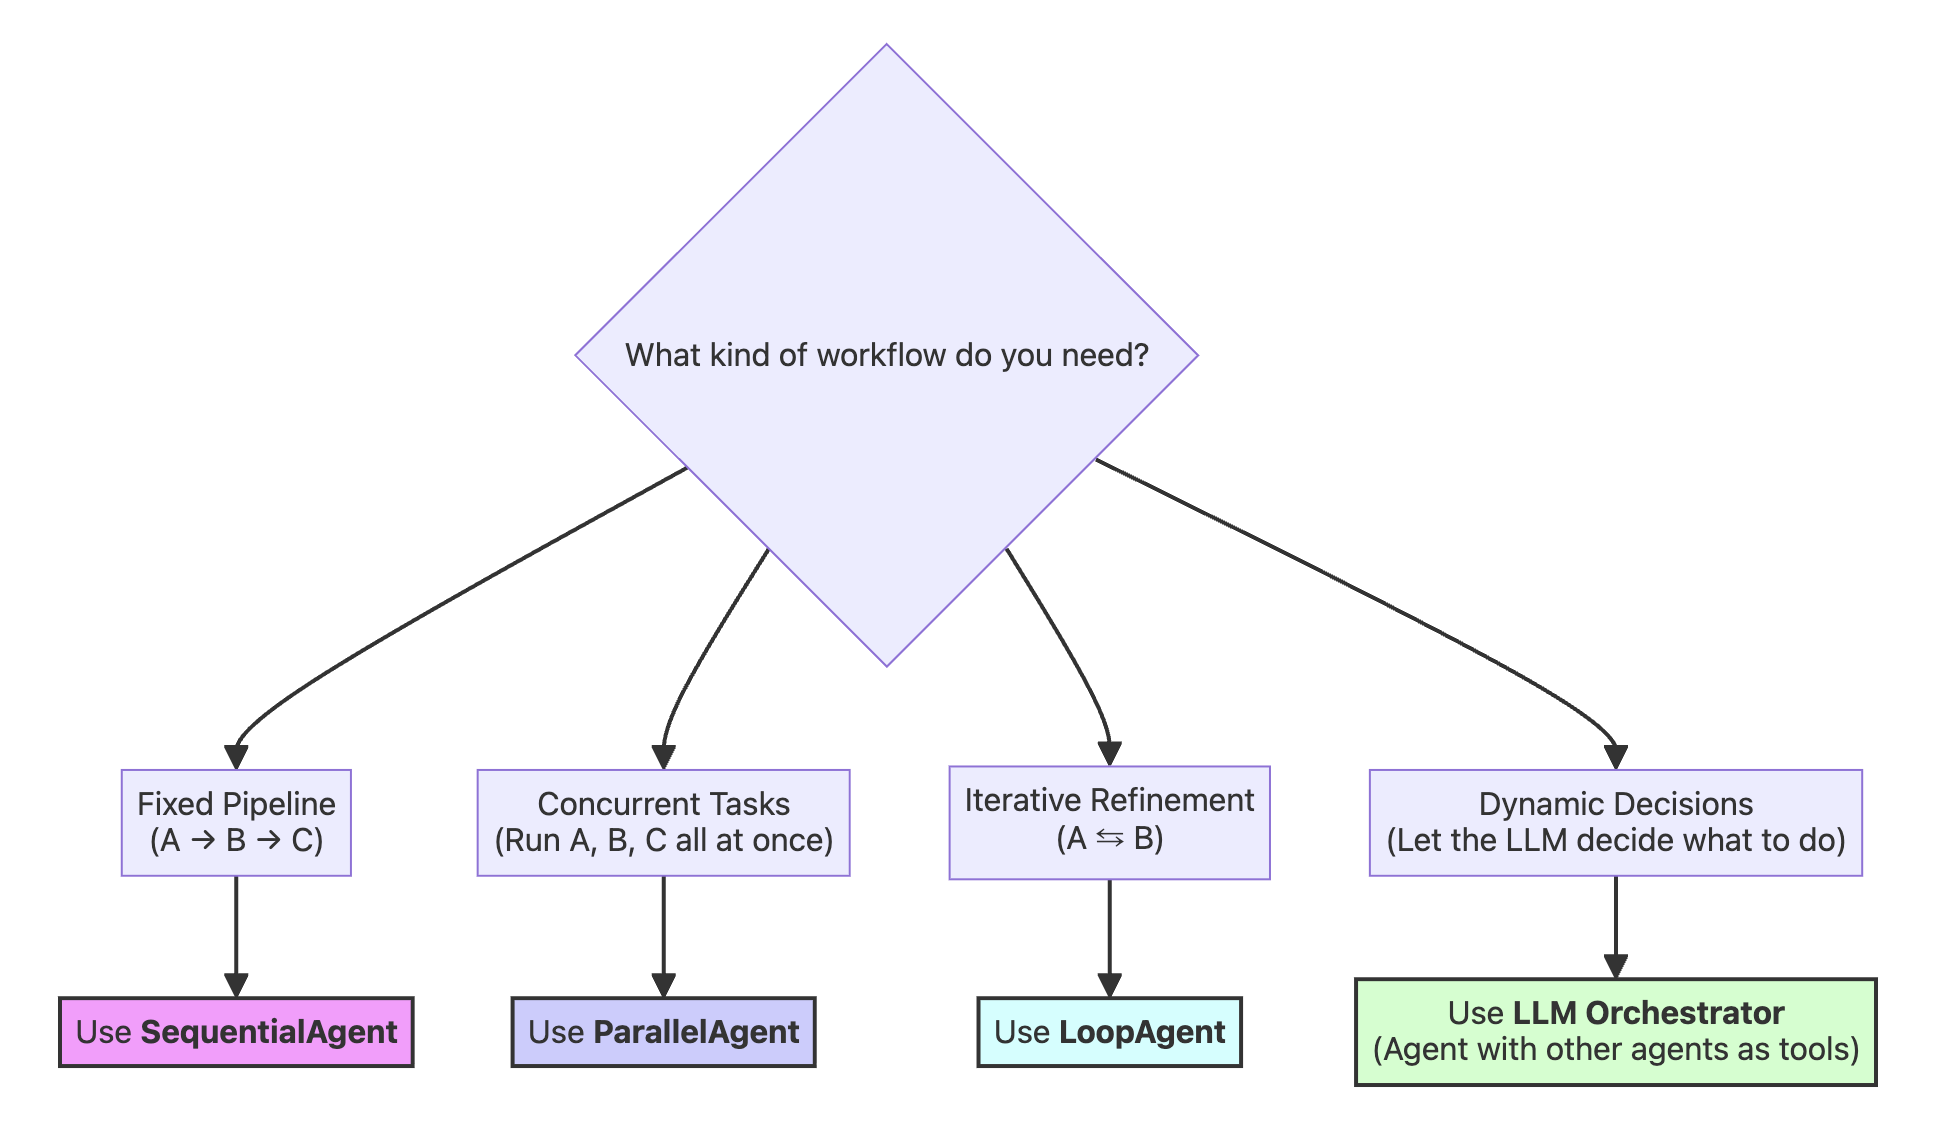